# 0. Import

In [ ]:
import os
import re
import torch
import joblib
import pprint
import gymnasium
import highway_env
import numpy as np
import pandas as pd
import torch.distributions as td
import highway_env.utils_FlowIS as FlowIS

from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.interpolate import splrep, splev
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import LineString, Point
from highway_env.Normalizing_Flow.maf import MAF
from rl_agents.trainer.evaluation import Evaluation
from highway_env.vehicle.behavior import IDMVehicle
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import norm, laplace, uniform, multivariate_normal
from rl_agents.agents.common.factory import load_agent, load_environment

from highway_env.utils_FlowIS import MarginalGaussianMixture,RejectAcceptSampling
from highway_env.utils_FlowIS import NormalProposalDistribution,MixedLaplaceUniform

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False


# 1. Data Process

### 1.1 intersection-NDEs

In [64]:
import numpy as np
import os

def merge_npy_files(folder_path, output_file=None):
    """
    读取文件夹中所有.npy文件，按行合并为一个数组
    
    :param folder_path: 存放.npy文件的文件夹路径
    :param output_file: 合并后保存的文件路径（可选）
    :return: 合并后的numpy数组
    """
    # 获取文件夹中所有.npy文件的路径
    npy_files = [
        os.path.join(folder_path, f) 
        for f in os.listdir(folder_path) 
        if f.endswith('.npy') and os.path.isfile(os.path.join(folder_path, f))
    ]
    
    if not npy_files:
        raise ValueError(f"文件夹 {folder_path} 中未找到.npy文件")
    
    # 读取所有文件并存储数组
    arrays = []
    for file in npy_files:
        arr = np.load(file)
        # 确保数组为二维（若为一维，转换为单列二维数组）
        if arr.ndim == 1:
            arr = arr.reshape(-1, 1)
        elif arr.ndim != 2:
            raise ValueError(f"文件 {file} 中的数组维度不为1或2，无法合并")
        arrays.append(arr)
    
    # 按行合并（纵向拼接）
    merged_array = np.vstack(arrays)
    
    # 若指定输出文件，则保存
    if output_file:
        np.save(output_file, merged_array)
        print(f"合并完成，已保存至 {output_file}")
    
    return merged_array

folder = r'E:\加速测试仿真数据\FlowIS\database'
output = r'E:\加速测试仿真数据\FlowIS\critical\intersection_data_all.npy'
scene_behavior = merge_npy_files(folder, output)

合并完成，已保存至 E:\加速测试仿真数据\FlowIS\critical\intersection_data_all.npy


In [66]:
dimension=[5,4]
Normalize_scene_behavior=MinMaxScaler()
Normalize_scene=MinMaxScaler()
Normalize_scene_behavior.fit(scene_behavior[:,:dimension[0]])
Normalize_scene.fit(scene_behavior[:,:dimension[1]])
scene_behavior_inter=Normalize_scene_behavior.transform(scene_behavior[:,:dimension[0]])
scene_inter=Normalize_scene.transform(scene_behavior[:,:dimension[1]])

In [67]:
gmm_inter = FlowIS.MarginalTruncatedGMM(n_components=15,
                                        random_state=42,
                                        bounds=[(0, 1)] * 5,
                                        precompute_dims=[[0, 1, 2, 3]])
gmm_inter.fit(scene_behavior_inter)

In [ ]:
import joblib 
from matplotlib import pyplot as plt
NDE_intersection=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_intersection.joblib')
accept=0
lenth=2.4
pet_list=[]
for _ in range(10000):
    scene_behavior=NDE_intersection['scene_behavior'].sample(n_samples=1)
    scene_behavior=NDE_intersection['fit_scene_behavior'].inverse_transform(scene_behavior)[0]
    ttcp_lt = (13 * np.arccos(9/13) + 100  - scene_behavior[0] -lenth) / (scene_behavior[1]+1e-8)
    ttcp_gs = (122 - np.sqrt(13**2 - 9**2) - scene_behavior[2] -lenth) / (scene_behavior[3]+1e-8)
    if np.abs(ttcp_lt-ttcp_gs)>=0.3:
        accept+=1
        pet_list.append(np.abs(ttcp_lt-ttcp_gs))

print(accept/10000)

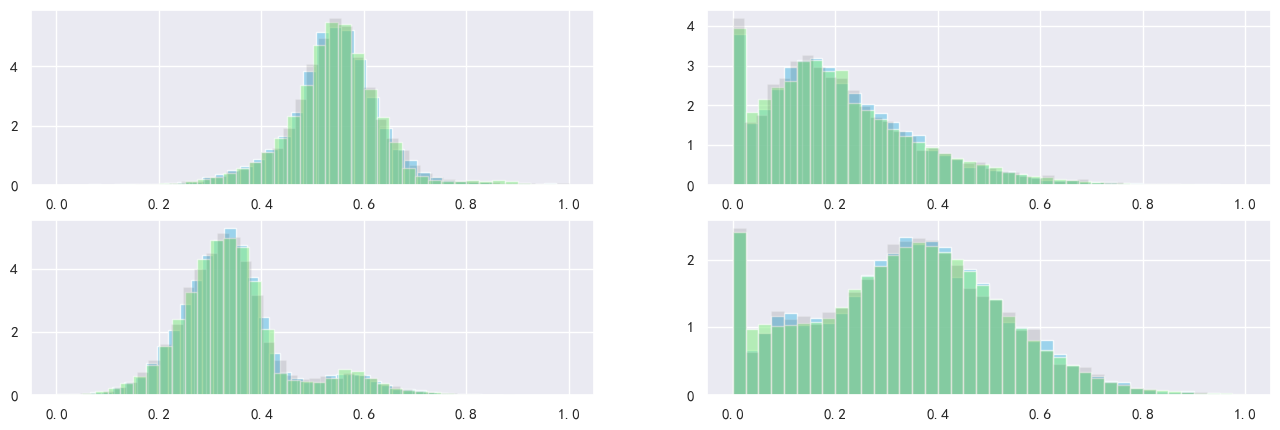

In [ ]:
samples=gmm_inter.sample(10000)
samples_marginal=gmm_inter.sample_marginal(10000,dims=[0,1,2,3])
fig, axes = plt.subplots(2, 2, figsize=(16, 5)) 
num_un=num_pa=0
for i in range(2):
    for j in range(2):  
        axes[i, j].hist(samples[:,2*i+j],density=True,bins=40,color='skyblue', alpha=0.8)
        axes[i, j].hist(scene_behavior_inter[:,2*i+j],density=True,bins=40,color='lightgreen', alpha=0.6)
        try:
            axes[i, j].hist(samples_marginal[:,2*i+j],density=True,bins=40,color='black', alpha=0.1)
        except:
            pass

验证归一化条件: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


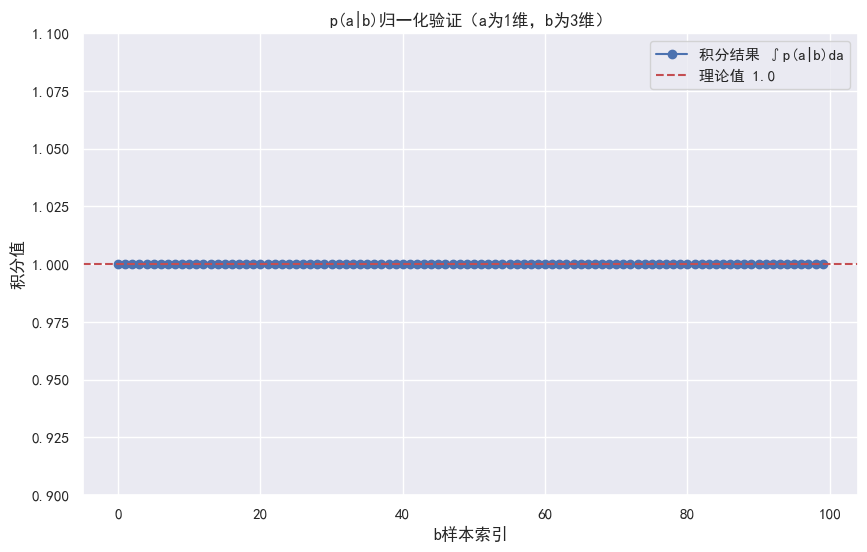

有效样本数：100/100
平均积分值：1.000000
积分标准差：0.000000
最大偏差：0.000000
是否严格满足归一化条件：是


In [ ]:
# Check whether the distribution of conditions meets the normalization condition

def verify_conditional_normalization(gmm_joint,  # GMM model for the multi-dimensional joint distribution p(a,b)
                                     dim=[0,1,2,3,4,5],
                                     a_range=(0, 1),  # Value range of a (adjust based on actual scenarios)
                                     b_samples=None,   # 3-dimensional samples of b (can be customized)
                                     num_a_points=1000,  # Number of discrete points for a
                                     num_b_samples=50):  # Number of samples for b
    """
    Verify the normalization condition of p(a|b): ∫p(a|b)da = 1
    
    Parameters:
    - gmm_joint: GMM model fitted to p(a,b) (4-dimensional: a(1D) + b(3D))
    - a_range: Integration range of a (min, max)
    - b_samples: 3-dimensional samples of b (automatically generated if None)
    - num_a_points: Number of discrete points for a (higher value means higher precision)
    - num_b_samples: Number of samples to generate for b
    """
    # 1. Generate 3-dimensional samples for b
    if b_samples is None:
        # If b samples are not provided, sample from the marginal distribution of b in GMM
        # (Assume b corresponds to dimensions [1,2,3], and a corresponds to dimension 0)
        # Note: Adjust 'dims' according to your GMM dimension definition (here, a is dimension 0, b is dimensions 1-3)
        b_samples = gmm_joint.sample_marginal(n_samples=num_b_samples, dims=dim)
    
    # 2. Discretize the integration interval of a
    a_min, a_max = a_range
    a_values = np.linspace(a_min, a_max, num_a_points)  # Discrete points for 1-dimensional a
    delta_a = (a_max - a_min) / (num_a_points - 1)  # Integration step size
    
    # 3. Calculate ∫p(a|b)da for each b sample
    integrals = []
    for b in tqdm(b_samples, desc="Verifying normalization condition"):
        # Reshape b from (3,) to (1,3) to match the input format of GMM
        b = b.reshape(1, -1)
        
        # Calculate marginal probability p(b): convert log(p(b)) to p(b)
        log_p_b = gmm_joint.logpdf_marginal(b, dims=dim)  # b corresponds to dimensions 1-3
        p_b = np.exp(log_p_b)
        if p_b < 1e-15:  # Avoid numerical instability caused by extremely small p(b)
            integrals.append(np.nan)
            continue
        
        # Calculate p(a|b) = p(a,b)/p(b) for each a value
        p_a_given_b_list = []
        for a in a_values:
            # Construct input for the joint distribution: (a, b0, b1, b2) -> shape (1,4)
            a_b = np.concatenate([b[0], [a]], axis=0).reshape(1, -1)
            
            # Calculate joint probability p(a,b) (full-dimensional calculation)
            log_p_ab = gmm_joint.logpdf(a_b)
            p_ab = np.exp(log_p_ab)
            
            # Calculate conditional probability p(a|b)
            p_a_given_b = p_ab / p_b
            p_a_given_b_list.append(p_a_given_b)
        
        # 4. Numerical integration: sum(p(a|b) * delta_a)
        integral = np.sum(p_a_given_b_list) * delta_a
        integrals.append(integral)
    
    # 5. Visualize and statistically analyze the results
    plt.figure(figsize=(10, 6))
    plt.plot(integrals, 'o-', label='Integration result ∫p(a|b)da')
    plt.axhline(y=1.0, color='r', linestyle='--', label='Theoretical value 1.0')
    plt.xlabel('b sample index')
    plt.ylabel('Integration value')
    plt.ylim(0.9, 1.1)
    plt.title(f'Normalization Verification of p(a|b) (a: 1D, b: 3D)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Statistical indicators (exclude NaN values)
    valid_integrals = np.array(integrals)[~np.isnan(integrals)]
    mean = np.mean(valid_integrals)
    std = np.std(valid_integrals)
    max_deviation = np.max(np.abs(valid_integrals - 1.0))
    
    print(f"Number of valid samples: {len(valid_integrals)}/{num_b_samples}")
    print(f"Mean integration value: {mean:.6f}")
    print(f"Standard deviation of integration: {std:.6f}")
    print(f"Maximum deviation: {max_deviation:.6f}")
    
    # Determine if normalization is satisfied (allow minor numerical errors)
    is_normalized = np.allclose(valid_integrals, 1.0, atol=1e-2)
    print(f"Strictly satisfies normalization condition: {'Yes' if is_normalized else 'No'}")
    
    return integrals, is_normalized

integrals, is_normalized=verify_conditional_normalization(gmm_inter, 
                                                          dim=[0,1,2,3],
                                                          a_range=(0, 1),  
                                                          b_samples=None,  
                                                          num_a_points=1000, 
                                                          num_b_samples=100)

In [ ]:
# Observe p(b|s) to design the proposal distribution
log_as_all_=[]
for _ in tqdm(range(10000)) :
    log_as=[]
    scene=gmm_inter.sample_marginal(n_samples=1, dims=[0,1,2,3])
    log_p_s=gmm_inter.logpdf_marginal(scene, dims=[0,1,2,3])
    behavior_list_ = np.linspace(0, 1, 101)  # 从0到1，共11个点（步长0.01）
    for behavior in behavior_list_:
        scene_behavior=np.concatenate([scene[0], [behavior]],axis=0).reshape(1,-1)
        log_p_sb=gmm_inter.logpdf(scene_behavior.reshape(1,-1))
        log_p_b=log_p_sb-log_p_s
        log_as.append(log_p_b)
    log_as_all_.append(log_as)
log_as_all_=np.array(log_as_all_)
log_as_all_=log_as_all_.squeeze()

100%|██████████| 10000/10000 [10:38<00:00, 15.66it/s]


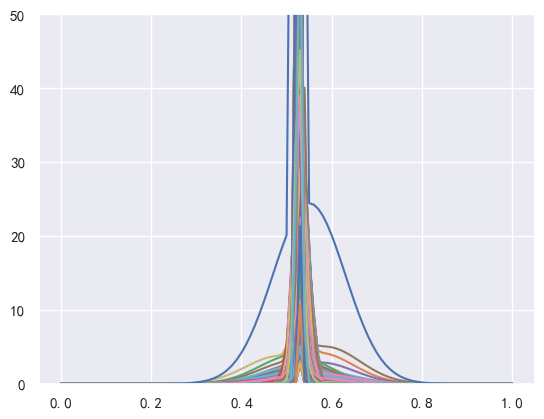

In [71]:
plt.ylim(0, 50)
for i in range(len(log_as_all_)):
    plt.plot(behavior_list_,np.exp(log_as_all_[i]))

M=7
proposal_accelerate=FlowIS.MixedNormalUniform(
                    normal_params={'loc': 0.55, 'scale': 0.08},  # 正态分布
                    uniform_params={'low': 0.51, 'high': 0.54},  # 中心均匀分布
                    mix_ratio=0.7
                    )
plt.plot(behavior_list_,M*np.exp(proposal_accelerate.logpdf(behavior_list_)))

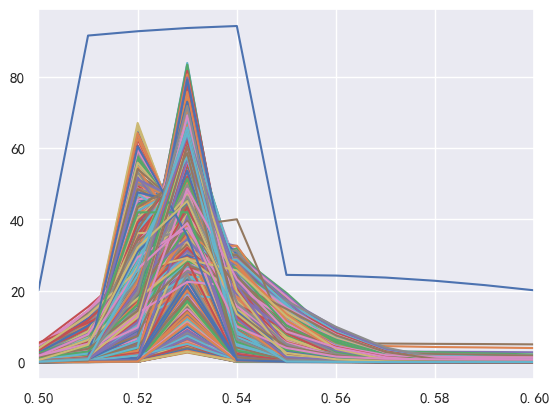

In [72]:
plt.xlim(0.5, 0.6)
for i in range(len(log_as_all_)):
    plt.plot(behavior_list_,np.exp(log_as_all_[i]))
plt.plot(behavior_list_,M*np.exp(proposal_accelerate.logpdf(behavior_list_)))

In [ ]:
# Store the valid dictionary after completing all the processes
NDE_intersection=dict()
NDE_intersection={'scene_behavior':gmm_inter,
                  'fit_scene_behavior':Normalize_scene_behavior,
                  'fit_scene':Normalize_scene,
                  'proposal_accelerate':proposal_accelerate,
                  'proposal_M':M
                  }

joblib.dump(NDE_intersection,r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_intersection.joblib')

['D:\\LocalSyncdisk\\加速测试\\code\\highway版本\\模型参数集合\\NDE_intersection.joblib']

In [ ]:
# Sampling Efficiency Test
from highway_env.vehicle.sampling import RejectAcceptSampling
NDE_intersection=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_intersection.joblib')

rates=0
for i in range(100):
    scene=NDE_intersection['scene_behavior'].sample_marginal(n_samples=1, dims=[0,1,2,3,])
    rate=RejectAcceptSampling.rejection_sampling_1D(scene,NDE_intersection,
                                                    dim=[0,1,2,3],
                                                    max_trials=100, random_state=None,
                                                    type='test')
    rates+=rate
rates/100

0.14320000000000008

### 1.2 intersection-FlowIS

In [37]:
Normalize_scene_behavior=MinMaxScaler()
Normalize_scene=MinMaxScaler()
Normalize_scene_behavior.fit(scene_behavior[:,:5])
Normalize_scene.fit(scene_behavior[:,0:4])

scene_behavior_inter=Normalize_scene_behavior.transform(scene_behavior_is_all[:,:5])
scene_behavior_train = np.hstack((scene_behavior_inter, 10*np.exp(-4*scene_behavior_is_all[:,[5]])))

In [35]:
epoch_loss=[]
epochs=300
# NDE_highway=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_highway.joblib')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = MAF(n_blocks=5,input_size=3,hidden_size=32,n_hidden=16)
model = MAF(n_blocks=10, input_size=5, hidden_size=100, n_hidden=1, cond_label_size=None,
                        activation='relu', input_order='sequential', batch_norm=True)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
model.train()

for epoch in tqdm(range(epochs)):
    np.random.shuffle(scene_behavior_train)
    feature = torch.from_numpy(scene_behavior_train[:10000,:5]).float()
    pet = torch.from_numpy(scene_behavior_train[:10000,5]).float()
    # 数据打包成TensorDataset和DataLoader
    dataset = TensorDataset(feature,pet)
    batch_size = 200
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    loader_loss=[]
    for i, data in enumerate(train_loader):
        if len(data) == 1:
            x, y = data[0], None
        else:
            x, y = data
            y = y.to(device)
        # prob_p=NDE_highway['scene_behavior'].logpdf(x)    
        x = x.view(x.shape[0], -1).to(device)
        prob_q=model.log_prob(x, None) 
        loss = (- y * prob_q ).mean(0)
        loader_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss.append(sum(loader_loss)/len(loader_loss))
    if epoch % 100 == 0:
        print('epoch {:3d} / {}; loss {:.4f}'.format(
            epoch, epochs, sum(loader_loss)/len(loader_loss)))
# plt.plot(epoch_loss)
# plt.savefig('plot.png')
# plt.close()
# Image(filename='plot.png')
# 保存模型参数
torch.save(model.state_dict(), r"D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\flow\scene_behavior_intersection.pth")

  0%|          | 1/300 [00:01<07:05,  1.42s/it]

epoch   0 / 300; loss -5.7586


 34%|███▎      | 101/300 [02:03<03:57,  1.19s/it]

epoch 100 / 300; loss -6.6485


 67%|██████▋   | 201/300 [04:06<02:02,  1.24s/it]

epoch 200 / 300; loss -6.3263


100%|██████████| 300/300 [06:13<00:00,  1.24s/it]


In [ ]:
def remove_nan_samples(x, min_val=0.0, max_val=1.0):
    """
    Remove samples from a tensor that contain NaN values or values outside the specified range
    
    Parameters:
        x: Input tensor with shape [batch_size, ...]
        min_val: Lower bound of the valid value range
        max_val: Upper bound of the valid value range
    
    Returns:
        Filtered tensor containing only valid samples
    """
    # Check if each sample contains any NaN value
    has_nan = torch.isnan(x).any(dim=1)
    
    # Check if each sample contains any value outside the specified range
    out_of_range = ((x < min_val) | (x > max_val)).any(dim=1)
    
    # Condition for valid samples: no NaN values and no values outside the range
    valid_mask = ~(has_nan | out_of_range)
    
    # Return the tensor filtered by valid samples
    return x[valid_mask]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = MAF(n_blocks=5,input_size=3,hidden_size=32,n_hidden=16)
model = MAF(n_blocks=10, input_size=5, hidden_size=100, n_hidden=1, cond_label_size=None,
                        activation='relu', input_order='sequential', batch_norm=True)
model = model.to(device)
model.load_state_dict(torch.load( r"D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\flow\scene_behavior_intersection.pth"))
model.eval() 
u = model.base_dist.sample((100000,)).squeeze()
samples, _ = model.inverse(u)
samples = remove_nan_samples(samples)
log_probs = model.log_prob(samples)  # sort by log_prob; take argsort idxs; flip high to low
log_probs=log_probs.sort(0)[1].flip(0).cpu()
samples=samples.cpu()
samples = samples[log_probs].detach().numpy()


In [42]:
gmm_inter = FlowIS.MarginalTruncatedGMM(n_components=15,
                                        random_state=42,
                                        bounds=[(0, 1)] * 5,
                                        precompute_dims=[[0, 1, 2, 3]])
# gmm_inter.fit(samples)
gmm_inter.fit(scene_behavior_inter)

验证归一化条件: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


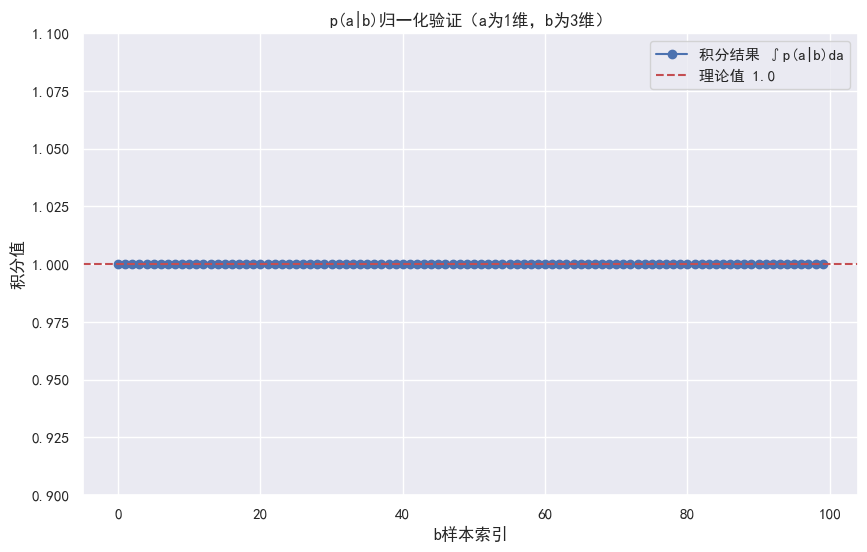

有效样本数：100/100
平均积分值：1.000000
积分标准差：0.000000
最大偏差：0.000000
是否严格满足归一化条件：是


In [ ]:
# Check whether the distribution of conditions meets the normalization condition
integrals, is_normalized=verify_conditional_normalization(gmm_inter, 
                                                          dim=[0,1,2,3],
                                                          a_range=(0, 1),  
                                                          b_samples=None,  
                                                          num_a_points=1000, 
                                                          num_b_samples=100)

In [46]:
# 观察p(b|s)，用于设计提议分布
def sample_for_proposal(distribution,dim):
    log_as_all_=[]
    for _ in tqdm(range(10000)) :
        log_as=[]
        scene=distribution.sample_marginal(n_samples=1, dims=dim)
        log_p_s=distribution.logpdf_marginal(scene, dims=dim)
        behavior_list_ = np.linspace(0, 1, 101)  # 从0到1，共11个点（步长0.01）
        for behavior in behavior_list_:
            scene_behavior=np.concatenate([scene[0], [behavior]],axis=0).reshape(1,-1)
            log_p_sb=distribution.logpdf(scene_behavior.reshape(1,-1))
            log_p_b=log_p_sb-log_p_s
            log_as.append(log_p_b)
        log_as_all_.append(log_as)
    log_as_all_=np.array(log_as_all_)
    log_as_all_=log_as_all_.squeeze()
    return behavior_list_,log_as_all_

behavior_list_,log_as_all_=sample_for_proposal(gmm_inter, [0,1,2,3])

100%|██████████| 10000/10000 [11:41<00:00, 14.25it/s]


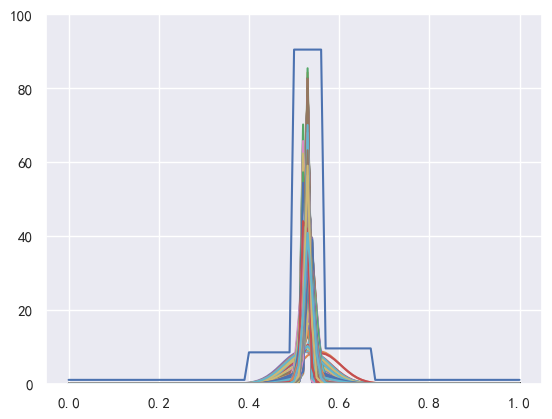

In [52]:
plt.ylim(0, 100)
for i in range(len(log_as_all_)):
    plt.plot(behavior_list_,np.exp(log_as_all_[i]))

# M=8
# proposal_accelerate=FlowIS.PiecewiseUniformDistribution([0, 0.46, 0.5, 0.57, 0.6, 1],[1,20,80,30,1])
M=9
proposal_accelerate=FlowIS.PiecewiseUniformDistribution([0, 0.4, 0.5, 0.57, 0.68, 1],[1,8,85,9,1])
plt.plot(behavior_list_,M*np.exp(proposal_accelerate.logpdf(behavior_list_)))

In [ ]:
NDE_intersection=dict()
NDE_intersection={'scene_behavior':gmm_inter,
                  'fit_scene_behavior':Normalize_scene_behavior,
                  'fit_scene':Normalize_scene,
                  'proposal_accelerate':proposal_accelerate,
                  'proposal_M':M
                  }

joblib.dump(NDE_intersection,r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\FlowIS_intersection.joblib')

['D:\\LocalSyncdisk\\加速测试\\code\\highway版本\\模型参数集合\\FlowIS_intersection.joblib']

In [54]:
# 采样效率测试
from highway_env.vehicle.sampling import RejectAcceptSampling
NDE_intersection=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\FlowIS_intersection.joblib')

rates=0
for i in range(100):
    scene=NDE_intersection['scene_behavior'].sample_marginal(n_samples=1, dims=[0,1,2,3])
    rate=RejectAcceptSampling.rejection_sampling_1D(scene,NDE_intersection,
                                                    dim=[0,1,2,3],
                                                    max_trials=100, random_state=None,
                                                    type='test')
    rates+=rate
rates/100

0.1065

# 2. ENV环境

### ego_agent PPO

In [1]:
# 训练PPO
import gymnasium
from stable_baselines3 import PPO

gymnasium.register(
    id='InDEnv-v0',
    entry_point='highway_env.envs:InDEnv',
)

env = gymnasium.make('InDEnv-v0',render_mode='rgb_array')

# 创建并训练模型 
model = PPO("MlpPolicy", env, verbose=1, n_steps= 20, batch_size= 64, n_epochs= 100)

test  = model.learn(total_timesteps=10_000)

# 保存模型到指定路径
model.save(r"D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\agent\PPO\20250723")


c:\Users\Administrator\anaconda3\envs\intersection\Lib\site-packages\gymnasium\envs\registration.py:644: UserWarning: WARN: Overriding environment InDEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\Administrator\anaconda3\envs\intersection\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 20`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 20
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=20 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Administrator\anaconda3\envs\intersection\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------
| time/              |    |
|    fps             | 34 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 20 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 40          |
| train/                  |             |
|    approx_kl            | 0.028356884 |
|    clip_fraction        | 0.425       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.0102      |
|    learning_rate        | 0.0003      |
|    loss                 | 2.42        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0728     |
|    value_loss           | 8.22        |
-----------------------------------------
----------------------------------------
| rollo

### FlowIS

In [ ]:
import os
import joblib
import gymnasium
import numpy as np
from tqdm import tqdm
from scipy.special import ndtri

result_=[]
simulation=[]
TDE_intersection=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\FlowIS_intersection.joblib')
NDE_intersection=joblib.load(r'D:\LocalSyncdisk\加速测试\code\highway版本\模型参数集合\NDE_intersection.joblib')
gymnasium.register(
    id='InDEnv-v0',
    entry_point='highway_env.envs:InDEnv',
)

def importance_mapping(FlowIS_highway,NDE_highway,scene_behavior,dim=[0,1,2,3]):
    scene_behavior=FlowIS_highway['fit_scene_behavior'].transform(scene_behavior)
    scene=scene_behavior[:,dim]
    prob_q_s_b=FlowIS_highway['scene_behavior'].logpdf(scene_behavior)[0]
    prob_q_s=FlowIS_highway['scene_behavior'].logpdf_marginal(scene, dim)  
    prob_p_s_b=NDE_highway['scene_behavior'].logpdf(scene_behavior)[0]
    prob_p_s=NDE_highway['scene_behavior'].logpdf_marginal(scene, dim)  
    return prob_p_s_b-prob_p_s-prob_q_s_b+prob_q_s

env = gymnasium.make('InDEnv-v0',render_mode='rgb_array')
# env.unwrapped.config.update({"distribution": control_distribution})
lenth=2.4
z_rate=0.95
step_lenth=10
half_width_base=1
dim_intersection=[0,1,2,3]
file = 'intersection_TDE_20250901'
folder_path = fr'E:\加速测试仿真数据\FlowIS\simulation\{file}'
os.makedirs(folder_path, exist_ok=True)
while half_width_base > 0.3: 
    for _ in tqdm(range(10000)):
        obs, info = env.reset()
        # 计算初始场景的概率
        scene_behavior=TDE_intersection['fit_scene_behavior'].transform(np.array([info['scene_behavior']]))
        prob_s_q=TDE_intersection['scene_behavior'].logpdf_marginal(scene_behavior[:,dim_intersection], dim_intersection) 
        prob_s_p=NDE_intersection['scene_behavior'].logpdf_marginal(scene_behavior[:,dim_intersection], dim_intersection) 
        prob=prob_s_p-prob_s_q

        scene_behavior_simulate=[]
        for _ in range(step_lenth):
            obs, reward, terminated, truncated, info = env.step(0)
            if terminated or truncated:
                break           
            # env.render()
            scene_behavior=np.array([info['scene_behavior']])
            prob+=importance_mapping(TDE_intersection,NDE_intersection,scene_behavior,dim_intersection)
            scene_behavior_simulate.append(info['scene_behavior'])

        if env.unwrapped.road.vehicles[0].crashed:
            result_.append([1,np.exp(prob).item()])  
        else:
            result_.append([0,np.exp(prob).item()])

        simulation.append(scene_behavior_simulate)   
        env.close()

    result=np.array(result_)   
    result=result[:,0]*result[:,1]
    collision_rate=np.mean(result)
    z = ndtri(1 - (1 - z_rate) / 2)
    if collision_rate != 0:
        half_width_base = z * np.std(result) / np.sqrt(len(result)) / collision_rate
    else:
        half_width_base = 1    
    print('simulation:',len(result),'    collision:',collision_rate,'    half_width:',half_width_base)

    joblib.dump(simulation, os.path.join(folder_path, 'scene_behavior.joblib'))
    joblib.dump(result_,os.path.join(folder_path, 'result.joblib'))
